# TimeGrad: Training and Inference on S&P500 Data

This notebook demonstrates how to run the TimeGrad model on S&P500 time-series data. It covers:

1.  **Data Fetching**: Downloading S&P500 data using `yfinance`.
2.  **Data Preparation**: Normalizing and converting data into a GluonTS-compatible format.
3.  **Model Training**: Training the TimeGrad model using a simplified Dataloader.
4.  **Inference**: Generating synthetic time-series samples using the trained model.
5.  **Visualization**: Comparing the synthetic data with the real data.

In [2]:
import sys
import os
from typing import List
import torch
import matplotlib.pyplot as plt
import numpy as np

# Add the project's root directory to the Python path.
# This allows us to import our custom modules like `data_fetch` and `src.pts`.
module_path = os.path.abspath(os.getcwd()) # Assumes notebook is in 'Grok Assisted' directory
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from gluonts.dataset.split import split

# Import from the modules directly
from src.pts.model.time_grad.diffusion import Diffusion, DiffusionConfig
from src.pts.model.time_grad.time_grad_network import TimeGradNetwork, NetworkConfig
from src.pts.model.time_grad.time_grad_estimator import TimeGradEstimator, EstimatorConfig
from src.pts.model.time_grad.time_grad_predictor import TimeGradPredictor
from src.pts.trainer import Trainer
from data_fetch import fetch_sp500_data, prepare_gluonts_dataset, DataConfig

print("Imports successful and path is set up.")

Imports successful and path is set up.


/opt/conda/envs/condatest/lib/python3.9/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## 1. Configuration

We define all the configurations for data, network, diffusion, and the estimator in one place.

In [3]:
# Data Configuration
# Use daily data ('1d') to fetch the full history from 2010.
# yfinance limits hourly ('1h') data to the last ~2 years.
data_config = DataConfig(
    symbol= 'BTC-USD',
    start_date='2020-01-01', 
    interval='1d',
    context_length=24, 
    prediction_length=24
)

# Network configuration
net_config = NetworkConfig(input_dim=1, hidden_dim=40, num_layers=2)

# Diffusion process configuration
diff_config = DiffusionConfig(num_steps=100, beta_start=1e-4, beta_end=0.1)

# Estimator/Training configuration
est_config = EstimatorConfig(learning_rate=1e-3, batch_size=64)

print("Configurations loaded.")

Configurations loaded.


## 2. Data Fetching and Preparation

We fetch the S&P 500 data, normalize it, and prepare it as a GluonTS dataset.

In [4]:
try:
    print("Fetching data...")
    # Fetch data
    df = fetch_sp500_data(data_config)
    print(f"Fetched {len(df)} data points")

    # Simple normalization
    data_mean = df['close'].mean()
    data_std = df['close'].std()
    df_normalized = df.copy()
    df_normalized['close'] = (df['close'] - data_mean) / data_std
    print(f"Data normalized - Mean: {data_mean:.2f}, Std: {data_std:.2f}")

    # Create dataset
    dataset = prepare_gluonts_dataset(df_normalized, data_config)
    print("Dataset prepared successfully")
except Exception as e:
    print(f"An error occurred during data fetching/preparation: {e}")

Fetching data...


[*********************100%***********************]  1 of 1 completed

Fetched 2069 data points
Data normalized - Mean: 43869.58, Std: 28988.19
Dataset prepared successfully


## 3. Data Splitting and Dataloader

The data is split into training and test sets. We then use a simple, custom data loader for training. This loader yields batches with the target data and initial hidden states for the RNN.

In [5]:
# Split data
# We only need the training part from the split for this script.
train_dataset, _ = split(dataset, offset=-data_config.prediction_length)
train_data = list(train_dataset)
        
print(f"Training data: {len(train_data)} series")

# Simple dataloader
class SimpleLoader:
    def __init__(self, ds, context_length, num_layers, hidden_dim):
        self.ds = ds
        self.context_length = context_length
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
                
    def __iter__(self):
        for item in self.ds:
            target_data = item['target']

            # Create sliding windows over the entire training series
            # to ensure the model sees all the data.
            for i in range(len(target_data) - self.context_length + 1):
                context_data = target_data[i : i + self.context_length]
                target_tensor = torch.tensor(
                    context_data.reshape(1, -1, 1), 
                    dtype=torch.float32
                )

                hidden = (
                    torch.zeros(self.num_layers, 1, self.hidden_dim),
                    torch.zeros(self.num_layers, 1, self.hidden_dim)
                )

                yield {
                    'target': target_tensor,
                    'hidden': hidden
                }

    def __len__(self):
        # The length is the total number of windows we can create.
        total_windows = 0
        for item in self.ds:
            total_windows += max(0, len(item['target']) - self.context_length + 1)
        return total_windows

train_loader = SimpleLoader(
    train_data, 
    data_config.context_length, 
    net_config.num_layers, 
    net_config.hidden_dim
)

print("Dataloader created.")

Training data: 1 series
Dataloader created.


## 4. Model Initialization

We initialize the core components of TimeGrad: the diffusion process, the noise prediction network, the estimator (which handles the loss), and the trainer.

In [6]:
print("Initializing models...")
# Initialize models
diffusion = Diffusion(diff_config)
network = TimeGradNetwork(net_config)
estimator = TimeGradEstimator(est_config, network, diffusion)
trainer = Trainer(estimator, epochs=10)

print("Models initialized.")

Initializing models...
Models initialized.


## 5. Training

Now, we train the model. The progress bar will show the status for each epoch.

In [7]:
print("Starting training...")
losses = trainer.train(train_loader)
print(f"Training completed. Final loss: {losses[-1]:.4f}")

Starting training...


100%|██████████| 2022/2022 [00:04<00:00, 414.36it/s]


Epoch 0 loss: 1.0129467195708721


100%|██████████| 2022/2022 [00:04<00:00, 438.33it/s]


Epoch 1 loss: 0.9832158913775084


100%|██████████| 2022/2022 [00:04<00:00, 452.87it/s]


Epoch 2 loss: 0.9906467903261722


100%|██████████| 2022/2022 [00:04<00:00, 438.82it/s]


Epoch 3 loss: 0.9972314335088938


100%|██████████| 2022/2022 [00:04<00:00, 449.76it/s]


Epoch 4 loss: 0.9886527803867436


100%|██████████| 2022/2022 [00:04<00:00, 446.61it/s]


Epoch 5 loss: 0.9998755332388345


100%|██████████| 2022/2022 [00:04<00:00, 448.52it/s]


Epoch 6 loss: 0.9965110499739764


100%|██████████| 2022/2022 [00:04<00:00, 437.28it/s]


Epoch 7 loss: 1.0032905593558659


100%|██████████| 2022/2022 [00:04<00:00, 447.13it/s]


Epoch 8 loss: 0.9859045250184694


100%|██████████| 2022/2022 [00:04<00:00, 417.20it/s]

Epoch 9 loss: 0.9830794110967899
Training completed. Final loss: 0.9831


## 6. Inference: Generating Synthetic Samples

With the trained network, we use the `TimeGradPredictor` to generate new time-series samples through the reverse diffusion process.

In [8]:
print("Generating synthetic samples...")
# Generate samples
predictor = TimeGradPredictor(network, diffusion)
samples = predictor.predict(
    context_length=data_config.prediction_length, 
    num_samples=100
)
print(f"Generated samples shape: {samples.shape}")

Generating synthetic samples...
Generated samples shape: torch.Size([100, 24])


## 7. Visualization and Analysis

Finally, we visualize the results. We denormalize the generated samples and plot them against the original data to qualitatively assess the model's performance.

Creating forecast visualization...
Target data range: 108410.8359375 123344.0625
Original forecast samples range: -1561006.9 1764177.4
Clipped forecast samples range: 4473.7095 135678.47
Target plot range std: 3146.69628192671
Clipped forecast samples std: 63275.598
Clipped Quantile 10.0%: 4473.70947265625 4473.70947265625
Clipped Quantile 50.0%: 4473.70947265625 135678.46875
Clipped Quantile 90.0%: 135678.46875 135678.46875


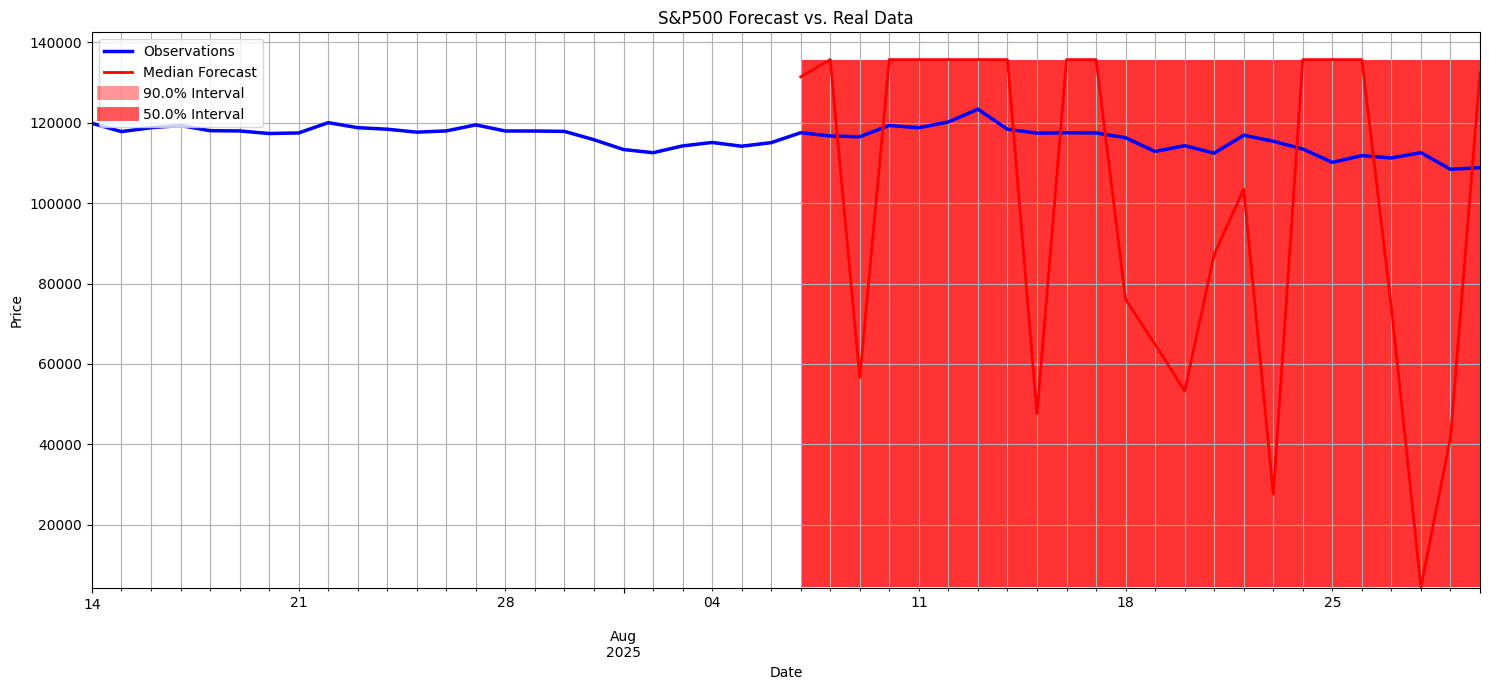


=== Results Summary ===
Real data      - Mean: 115305.85, Std: 3667.14
Median forecast - Mean: 115980.28, Std: 59861.69


In [15]:
import pandas as pd

# Helper class to mimic GluonTS/PyTorchTS Forecast object
class SimpleForecast:
    """
    A simplified forecast object that holds samples and can compute quantiles.
    This is to make the generated samples compatible with plotting utilities
    that expect a forecast-like object.
    """

    def __init__(self, samples, start_date, freq):
        # samples are expected to be denormalized, shape: (num_samples, prediction_length)
        self.samples = samples
        self.start_date = start_date
        self.freq = freq
        self.prediction_length = samples.shape[1]

        # Create a pandas DatetimeIndex for the forecast horizon
        self.index = pd.date_range(
            start=self.start_date, periods=self.prediction_length, freq=self.freq
        )

    def quantile(self, q: float) -> np.ndarray:
        """
        Compute a quantile of the samples.

        Args:
            q: The quantile to compute (e.g., 0.5 for median).

        Returns:
            An array of shape (prediction_length,).
        """
        return np.quantile(self.samples, q, axis=0)


def plot_forecast(
    target: pd.Series,
    forecast: 'SimpleForecast',
    prediction_length: int,
    prediction_intervals: tuple = (50.0, 90.0),
    color: str = "g",
):
    print("Creating forecast visualization...")
    # Dynamically adjust plot width based on the number of observations
    dynamic_width = max(15, prediction_length / 4)
    
    # Create a single plot
    plt.figure(figsize=(dynamic_width, 7))
    ax = plt.gca()

    # Plot the target data
    target_plot_range = target.iloc[-2 * prediction_length :]
    target_plot_range.plot(ax=ax, label="Observations", color="blue", linewidth=2.5)

    # Clip forecast samples to a reasonable range based on target data
    clipped_samples = np.clip(
        forecast.samples,
        target.min() * 0.9,
        target.max() * 1.1
    )
    forecast_clipped = SimpleForecast(
        samples=clipped_samples,
        start_date=forecast.start_date,
        freq=forecast.freq
    )

    # Define the percentiles to calculate for the prediction intervals
    ps = [50.0] + [50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, 1.0]]
    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    # Get quantile data from the clipped forecast object
    ps_data = [forecast_clipped.quantile(p / 100.0) for p in percentiles_sorted]
    i_p50 = len(percentiles_sorted) // 2

    # Plot the median forecast
    p50_data = ps_data[i_p50]
    p50_series = pd.Series(data=p50_data, index=forecast.index)
    p50_series.plot(ax=ax, color=color, ls="-", label="Median Forecast", linewidth=2.0)

    # Plot the prediction intervals as shaded areas
    for i in range(len(percentiles_sorted) // 2):
        ptile = percentiles_sorted[i]
        alpha = alpha_for_percentile(ptile)
        ax.fill_between(
            forecast.index,
            ps_data[i],
            ps_data[-i - 1],
            facecolor=color,
            alpha=alpha,
            interpolate=True,
        )
        pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
            ax=ax, color=color, alpha=alpha, linewidth=10, label=f"{100 - ptile * 2}% Interval",
        )

    # Set y-axis limits to focus on the target data's range, with slight padding
    y_min = min(target_plot_range.min(), clipped_samples.min()) * 0.95
    y_max = max(target_plot_range.max(), clipped_samples.max()) * 1.05
    ax.set_ylim(y_min, y_max)

    # Set titles and labels
    ax.set_title("S&P500 Forecast vs. Real Data")
    ax.set_ylabel("Price")
    ax.set_xlabel("Date")
    ax.legend(loc="upper left")
    ax.grid(which="both")

    # Debugging prints
    print("Target data range:", target_plot_range.min(), target_plot_range.max())
    print("Original forecast samples range:", forecast.samples.min(), forecast.samples.max())
    print("Clipped forecast samples range:", clipped_samples.min(), clipped_samples.max())
    print("Target plot range std:", target_plot_range.std())
    print("Clipped forecast samples std:", clipped_samples.std())
    for p in [10.0, 50.0, 90.0]:
        print(f"Clipped Quantile {p}%:", 
              forecast_clipped.quantile(p / 100.0).min(), 
              forecast_clipped.quantile(p / 100.0).max())

    plt.tight_layout()
    plt.show()

 # --- Plotting and Evaluation ---

# 1. Denormalize the generated samples
denormalized_samples = samples.detach().numpy() * data_std + data_mean

# 2. Determine the forecast start date and frequency
forecast_start_date = df.index[-data_config.prediction_length]
freq = "h" if data_config.interval == "1h" else "D"

# 3. Create the forecast object
forecast_obj = SimpleForecast(
    samples=denormalized_samples, start_date=forecast_start_date, freq=freq
)

# 4. Plot the forecast using the new, more detailed function
plot_forecast(
    target=df["close"],
    forecast=forecast_obj,
    prediction_length=data_config.prediction_length,
    color="r",  # Use red for the forecast
)

# 5. Print statistics for comparison
original_data = df['close'][-data_config.prediction_length:].values
median_forecast = forecast_obj.quantile(0.5)

print("\n=== Results Summary ===")
print(f"Real data      - Mean: {np.mean(original_data):.2f}, Std: {np.std(original_data):.2f}")
print(f"Median forecast - Mean: {np.mean(median_forecast):.2f}, Std: {np.std(median_forecast):.2f}")
